# AIAIART #9 - Evolutionary Algorithms and CPPNs

![Monolith GIF](https://thumbs.gfycat.com/GrouchyAnnualAldabratortoise-size_restricted.gif)

Throughout this course we've focused on OPTIMIZATION using techniques based on gradient descent to navigate the loss landscape. We've seen how this can often let us update the parameters of some network to do some really neat things. 

One way to think of this is as a search problem. We'd like to find a 'good' point in parameter space. Today, we'll try a different approach. Why deviate from a working formula?
- Some operations don't give nice gradients - which is a problem for gradient-based optimization!
- Sometimes we don't have or want a fixed number of parameters, or a set architecture
- Perhaps the kinds of solutions we can 'find' with gradient-based methods are holding us back from some new breakthrough
- Nature doesn't always do SGD
- Change is fun
- 'Evolutionary Computation' just sounds cool
- ...

With those justifications, let's dive in!

NB: I accidentally used this notebook during the lesson instead of making a scratchpad version, so it might be a little disordered until I tidy things up tomorrow for the YouTube recording. Apologies for any issues!


In [ ]:
#@title Lesson Video
import IPython.display as ipd
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/2F_sUjkjwps" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

## Section 1: Evolution and Natural Selection

![picture of a wasp](https://inaturalist-open-data.s3.amazonaws.com/photos/182227913/medium.jpg)

The natural world is filled with an incredible diversity of organisms each seemingly hyper-suited to their environmental niches. Where did all of this complexity come from? Scientists from Darwin to Dawkins have a staggeringly simple answer: natural selection.

Genes which code for 'fitter' organisms are more likely to be passed on. Any beneficial changes to these genes (arrived at through random mutation or recombination via sexual reproduction) has a higher chance of spreading as successive generations with this beneficial change outcompete those that without it. 

This is an imperfect process, and a slow one. But it is nonetheless a powerful mechanism, and one which computer scientists for many years have been inspired to imitate.

In [ ]:
!pip install -q neat-python

     |████████████████████████████████| 44 kB 1.4 MB/s 


## 1.1 Genetic Algorithms

![DNA gif](https://c.tenor.com/CHMG75vBlHgAAAAC/dinosaur-jurassic.gif)

GAs are a class of evolutionary algorithms directly inspired by the process we see in nature. We typically create some sort of population, which is a collection of individuals/genomes/phenotypes/creatures/etc. each with a set of properties (genotype/chromosome/...) that can be mutated and altered. 

Individuals within this population are evaluated based on a fitness function, which is typically an `objective function` we want to maximise. The fittest individuals are *stochastically* secected and their genomes are modified (via mutation or recombination) to give a new population - the 'next generation'. 

By repeating this process, we hope that over time the population will become better and better according to our fitness function.

There are a number of things to consider when designing a genetic algorithm:
- Initialisation: How big is our starting population? Random or 'seeded' near potential solutions?
- Objective function: How do we measure fitness?
- Genetic operations: How do we change the genomes? Randomly flipping bits in a binary representation? Replacing nodes in a graph? Randomly tweaking floats?
- Selection Criteria: How random will we be? How many do we 'keep' after each generation?
- Additional Heuristics: Should we try to maintain diversity within the population by modifying the selection criteria? Are there other things we should reward, such as relative simplicity?
- Termination: When do we stop? A set number of generations? Once a specified fitness is reached?

It's fun to try an implement something like this yourself - as attested by the many YouTube videos and project blogs of many who ahve gone before us. But for this lesson I'm going to rely instead on [an existing implementation](https://neat-python.readthedocs.io/en/latest/neat_overview.html) of an approach called 'NEAT' (NEUROEVOLUTION OF AUGMENTING
TOPOLOGIES - [check out the original paper](http://nn.cs.utexas.edu/downloads/papers/stanley.cec02.pdf)). 

For this first demo (adapted from the neat-python docs), we'll solve a very simple task - XOR.

In [ ]:
#@title visualization helpers
%%writefile visualize.py
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

Writing visualize.py


neat-python uses config files to specify the many parameters required - feel free to experiment with changing these or check out [the docs](https://neat-python.readthedocs.io/en/latest/config_file.html) for more information.

In [ ]:
#@title Config file
%%writefile config-xor
#--- parameters for the XOR-2 experiment ---#

[NEAT]
fitness_criterion     = max
fitness_threshold     = 3.9
pop_size              = 150
reset_on_extinction   = False

[DefaultGenome]
# node activation options
activation_default      = sigmoid
activation_mutate_rate  = 0.0
activation_options      = sigmoid

# node aggregation options
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# node bias options
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

# genome compatibility options
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

# connection add/remove rates
conn_add_prob           = 0.5
conn_delete_prob        = 0.5

# connection enable options
enabled_default         = True
enabled_mutate_rate     = 0.01

feed_forward            = True
initial_connection      = full

# node add/remove rates
node_add_prob           = 0.2
node_delete_prob        = 0.2

# network parameters
num_hidden              = 0
num_inputs              = 2
num_outputs             = 1

# node response options
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_max_value      = 30.0
response_min_value      = -30.0
response_mutate_power   = 0.0
response_mutate_rate    = 0.0
response_replace_rate   = 0.0

# connection weight options
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_max_value        = 30
weight_min_value        = -30
weight_mutate_power     = 0.5
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 20
species_elitism      = 2

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Writing config-xor



 ****** Running generation 0 ****** 

Population's average fitness: 2.22598 stdev: 0.37814
Best fitness: 2.99207 - size: (1, 2) - species 1 - id 50
Average adjusted fitness: 0.575
Mean genetic distance 1.007, standard deviation 0.470
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      3.0    0.575     0
Total extinctions: 0
Generation time: 0.018 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.34237 stdev: 0.31767
Best fitness: 2.99224 - size: (1, 2) - species 1 - id 170
Average adjusted fitness: 0.539
Mean genetic distance 1.088, standard deviation 0.506
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      3.0    0.539     0
Total extinctions: 0
Generation time: 0.018 sec (0.018 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.31323 stdev: 0

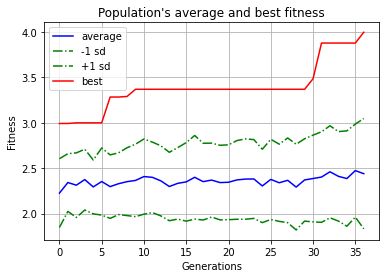

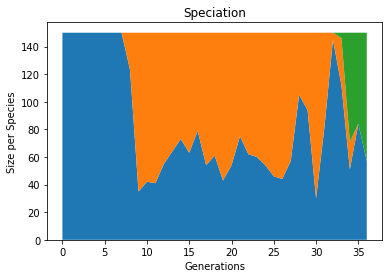

In [ ]:
# XOR Demo from the neat-python docs

import neat
import visualize

# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [(0.0,), (1.0,), (1.0,), (0.0,)]

# How we calculate the fitness for each genome:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2

# Load configuration.
config_file = 'config-xor'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                      neat.DefaultSpeciesSet, neat.DefaultStagnation,
                      config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress
p.add_reporter(neat.StdOutReporter(True))

# Also log progress for later visualization and save checkpoints every 5 generations:
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to 300 generations.
winner = p.run(eval_genomes, 300)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(xor_inputs, xor_outputs):
    output = winner_net.activate(xi)
    print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

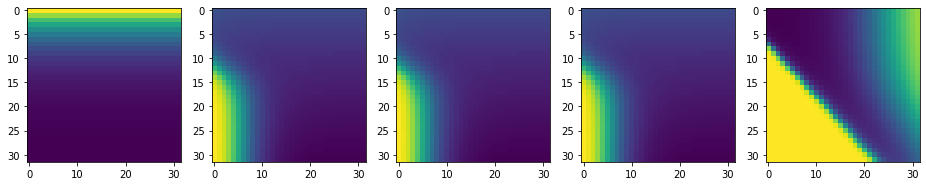

In [ ]:
#@title View performance at different stages
from matplotlib import pyplot as plt
import numpy as np

# Runs will vary, pick a few points of interest for yours
saves_to_view = [4, 9, 14, 19, 34] #@param

# Load the checkpoints and plot outputs for a grid (0, 1)
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
x, y = np.meshgrid(np.linspace(0, 1, 32), np.linspace(0, 1, 32))
coords = np.stack([x.flatten(), y.flatten()]).T
for i, gen in enumerate(saves_to_view): 
    p_gen = neat.Checkpointer.restore_checkpoint(f'neat-checkpoint-{gen}')
    eval_genomes(p_gen.population.items(), config) # Calculate fitness
    genomes = list(p_gen.population.values())
    best_genome = sorted(genomes, key=lambda g: g.fitness)[-1] # Get the best
    best_net = neat.nn.FeedForwardNetwork.create(best_genome, config)
    outs = np.array([best_net.activate(c) for c in coords]).reshape(32, 32)
    axs[i].imshow(outs)

In [ ]:
!rm neat-checkpoint* # clean up files

So what kinds of networks can we 'evolve'? Pretty much anything goes, but for practical reasons it's probably best to stick to fairly small networks. In the next demo, we'll take a look at a lovely class of models: Compositional Pattern Producing Networks (CPPNs, not CPNNs as I keep calling them in the video). 

## 1.2 Evolving CPPNs



If the name [Kenneth Stanley](https://twitter.com/kenneth0stanley) in the tweet below is familiar, it's probably because he's also the inventor of NEAT (from the previous section) as well as all sorts of other things, and currently does some amazing work on open-endedness at OpenAI. And if [Sebastian Risi](https://twitter.com/risi1979)'s name is familiar you've probably been doing your homework on self-organising systems from lesson 8 and found his post ['The Future of Artificial Intelligence is Self-Organizing and Self-Assembling'](https://sebastianrisi.com/self_assembling_ai/)

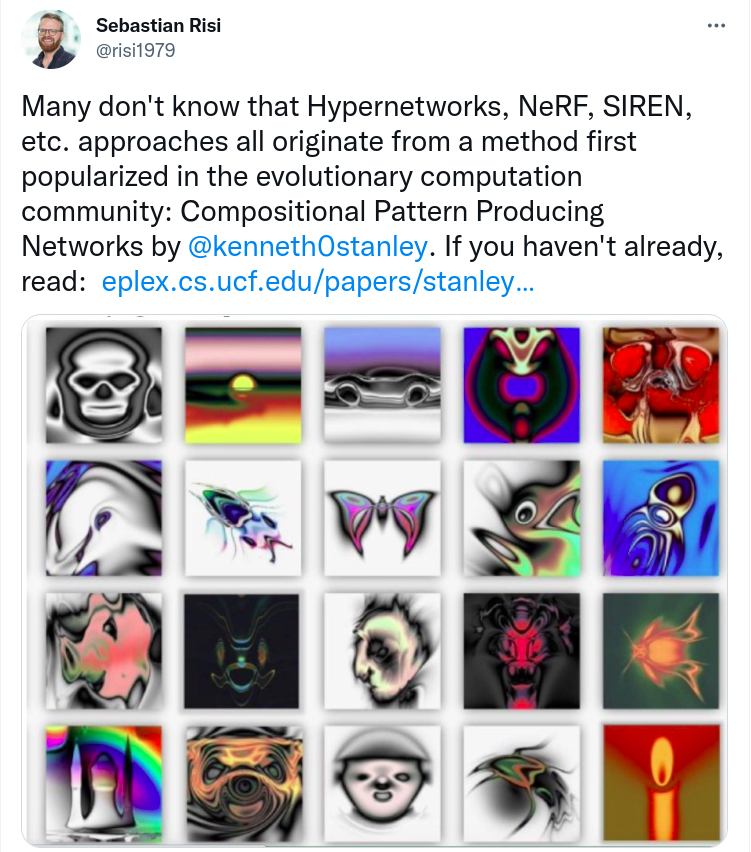

[This](http://eplex.cs.ucf.edu/papers/stanley_gpem07.pdf) is the paper linked in the tweet above, and the pictures come from the [wonderful Picbreeder project](http://eplex.cs.ucf.edu/papers/secretan_ecj11.pdf). The original picbreeder website is sadly down, but you can explore a similar idea via [this implementation](https://nbenko1.github.io/#/evolve).

Picbreeder used human beings as the fitness function - users collaborated by selecting and 'evolving' their favourite CPPNs. 

Let's run the demo and then talk more about what these are, why they're neat (pun intended) and how we can use some of these ideas in a deep learning context.

In [ ]:
#@title config for color CPPNs
%%writefile config-color
# The `NEAT` section specifies parameters particular to the NEAT algorithm
# or the experiment itself.  This is the only required section.
[NEAT]
fitness_criterion     = max
fitness_threshold     = 0.99
pop_size              = 300
reset_on_extinction   = False

[DefaultGenome]
num_inputs              = 2
num_hidden              = 12
num_outputs             = 3
initial_connection      = partial_direct 0.25
feed_forward            = True
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.8
conn_add_prob           = 0.1
conn_delete_prob        = 0.1
node_add_prob           = 0.1
node_delete_prob        = 0.1
activation_default      = random
activation_options      = sigmoid tanh abs gauss identity sin relu
activation_mutate_rate  = 0.1
aggregation_default     = sum
aggregation_options     = sum product
aggregation_mutate_rate = 0.1
bias_init_mean          = 0.0
bias_init_stdev         = 2.0
bias_replace_rate       = 0.1
bias_mutate_rate        = 0.1
bias_mutate_power       = 0.1
bias_max_value          = 30.0
bias_min_value          = -30.0
response_init_mean      = 1.0
response_init_stdev     = 0.2
response_replace_rate   = 0.1
response_mutate_rate    = 0.1
response_mutate_power   = 0.1
response_max_value      = 30.0
response_min_value      = -30.0

weight_max_value        = 30
weight_min_value        = -30
weight_init_mean        = 0.0
weight_init_stdev       = 2.0
weight_mutate_rate      = 0.1
weight_replace_rate     = 0.1
weight_mutate_power     = 0.1
enabled_default         = True
enabled_mutate_rate     = 0.02

[DefaultSpeciesSet]
compatibility_threshold = 5.0

[DefaultStagnation]
max_stagnation  = 10
species_elitism = 2

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.5

Writing config-color


In [ ]:
# Possible activations: sigmoid tanh abs gauss identity sin relu elu lelu selu softplus clamped inv log exp hat square cube

In [ ]:
!git clone https://github.com/johnowhitaker/PyTorch-NEAT

Cloning into 'PyTorch-NEAT'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 81 (delta 15), reused 22 (delta 8), pack-reused 47
Unpacking objects: 100% (81/81), done.


In [ ]:
import neat
import sys
sys.path.append('PyTorch-NEAT/')
from pytorch_neat.cppn import create_cppn
import torch
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
size=128
x, y = np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))
xs = [t for t in torch.tensor(np.stack([x.flatten(), y.flatten()]))] # Explain
print(xs[0].shape)

torch.Size([16384])


In [ ]:
# Load in the config 
config_file = 'config-color'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                      neat.DefaultSpeciesSet, neat.DefaultStagnation,
                      config_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


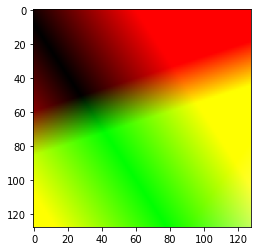

In [ ]:
# Create a new population and pic a random output
p_new = neat.Population(config) # New, random population
keys = list(p_new.population.keys())
genome = p_new.population[keys[0]]
nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
[r_node, g_node, b_node] = nodes
out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                      g_node.activate(xs, xs[0].shape).reshape(size, size),
                      b_node.activate(xs, xs[0].shape).reshape(size, size)])
plt.imshow(out_im.permute(1, 2, 0))

In [ ]:
# print(genome) # View the genome

In [ ]:
mse = torch.nn.MSELoss()
target_im = out_im*0.99 # Use the above as a target (we could also load an image or do torch.rand(3, 128, 128))
def eval_genomes(genomes, config, target_im=target_im):
  for genome_id, genome in genomes:
    nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
    [r_node, g_node, b_node] = nodes
    out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                          g_node.activate(xs, xs[0].shape).reshape(size, size),
                          b_node.activate(xs, xs[0].shape).reshape(size, size)])
    error = mse(target_im, out_im)
    genome.fitness = float(1-error)

In [ ]:
# Now evolve a new population to try and match that:

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run until we it target fitness or reach 50 generations
winner = p.run(eval_genomes, 50)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))


 ****** Running generation 0 ****** 

Population's average fitness: -2.04932 stdev: 2.80385
Best fitness: 0.58170 - size: (15, 16) - species 1 - id 256
Average adjusted fitness: 0.816
Mean genetic distance 3.993, standard deviation 0.226
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   300     -2.0    0.816     0
Total extinctions: 0
Generation time: 0.440 sec

 ****** Running generation 1 ****** 

Population's average fitness: -1.02381 stdev: 2.15529
Best fitness: 0.72037 - size: (15, 16) - species 1 - id 334
Average adjusted fitness: 0.858
Mean genetic distance 4.029, standard deviation 0.177
Population of 300 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   300     -1.0    0.858     0
Total extinctions: 0
Generation time: 0.420 sec (0.430 average)

 ****** Running generation 2 ****** 

Population's average fitness: -0.72248 

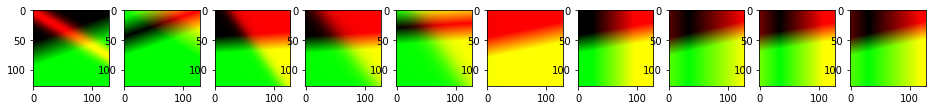

In [ ]:
# View the evolution over time
fig, axs = plt.subplots(1, 10, figsize=(16, 4))
for i, gen in enumerate(range(4, 50, 5)):
    p_gen = neat.Checkpointer.restore_checkpoint(f'neat-checkpoint-{gen}')
    # View the 'best  # TODO for some reason los=t code to rescore and get best???
    keys = list(p_gen.population.keys())
    genome = p_gen.population[keys[0]]
    nodes = create_cppn(genome, config, ['x', 'y'], ['r','g','b']+list(range(len(genome.nodes)-3)))
    [r_node, g_node, b_node] = nodes
    out_im = torch.stack([r_node.activate(xs, xs[0].shape).reshape(size, size),
                        g_node.activate(xs, xs[0].shape).reshape(size, size),
                        b_node.activate(xs, xs[0].shape).reshape(size, size)])
    axs[i].imshow(out_im.clip(0, 1).permute(1, 2, 0))

In [ ]:
# print(winner) # Compare to the earlier genome

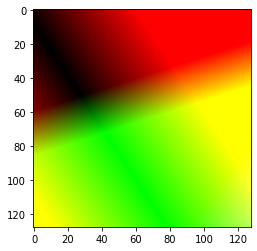

In [ ]:
plt.imshow(target_im.clip(0, 1).permute(1, 2, 0))

In [ ]:
# Exercise: Can you use CLIP in the fitness function to try to match a description?

Some examples from a quick first attepmt:

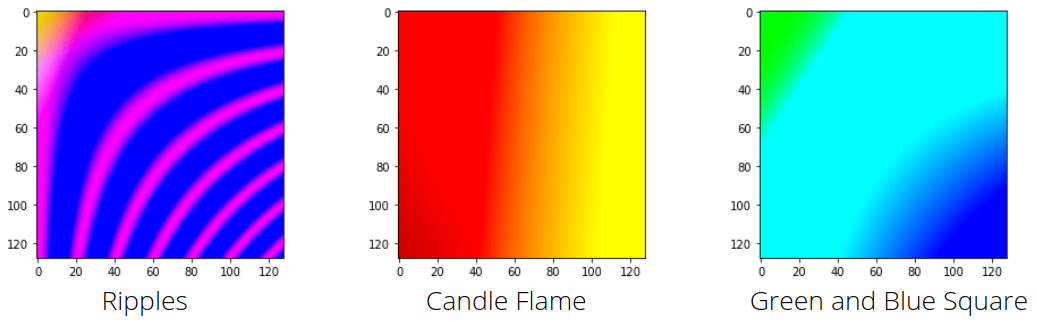

If you manage to create some more complex patterns with this I'd love to hear about it - please reach out if you can evolve a face based on a text prompt for example. I didn't have much luck in the few hours of playing I've done so far.

Looking for a slightly less trivial example? Check out [Modern Evolution Strategies for Creativity: Fitting Concrete Images and Abstract Concepts](https://es-clip.github.io/) from a few researchers at Google Brain or some of the other examples bundled with [Evo-JAX](https://github.com/google/evojax)

# Section 2: Back to Gradient-Based Methods

![welcome back gif](https://i.gifer.com/6esr.gif)

A big advantage of evolutionary techniques like NEAT is that they aren't stuck with a fixed structure or a set number of parameters. But, as you may have discovered if you've tried to evolve anything more complicated, evolutionary methods can be SLOW. 

Where EAs might start with a relatively simple network and try to evolve up to the bare minimum of complexity, in deep learning we often start with a comically large network ('overparametrised') and hope that within this large network we'll end up with simpler structures that get the job done. The evolutionary computing folks are always looking for ways to deal with larger systems (see HyperNEAT and many other approaches) and the DL folks have tools like regularization, model pruning or distillation to try and slim down their big models.

We're going to move back to the deep learning side of the fence, and we'll see how the idea of representing a signal (like an image) as a function of some inputs (such as the x and y coordinates we passed into the CPPNs above) finds some practical applications.



## 2.1 SIRENs

![walrus gif](https://i.gifer.com/8N9W.gif)

Say you'd like to represent a signal like a sound or an image. You could store values in a regular arrangement (like samples in a wav file, or pixels in an image). Or you could try to use various signal-processing tricks to decompose the signal into different components. Or maybe we could somehow LEARN a representation?

Let's go with the example of an image. We can imagine a network that takes in (x, y) coordinates as input and produces 3 outputs, just like the CPPNs in the previous section. We could evolve such a network, or we could specify the architecture in advance and learn the parameters via gradient descent. 

This kind of approach sounds promising! We can set the number of parameters, and thus define how much compression we'd like to have (since this number could give a network that is much smaller than the input image). The representation is independant of resolution (since we can pass in arbitrary x, y pairs and get an output). And with this implicit representation we can talk meaningfully about things like spatial gradients in an image, something which is harder when dealing with discrete pixels.

What should such a network look like? We could make a simple MLP (with a choice of activation functions) but it turns out these aren't great at capturing high-frequency details. Enter sinusoidal representation networks (Sirens) which 'leverage periodic activation functions for implicit neural representations'. 

Original paper: https://arxiv.org/abs/2006.09661
Improvements: https://arxiv.org/abs/2104.03960

Let's dig into one of these networks and learn by example:



In [ ]:
# Example (based on https://github.com/lucidrains/siren-pytorch)

In [ ]:
!pip install siren-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from siren_pytorch import Sine, Siren, SirenNet, SirenWrapper

In [ ]:
# The activation (a wrapper around torch.sin):
act = Sine(1.)
coords = torch.randn(1, 2)
coords, act(coords) 

(tensor([[-0.7983,  0.6456]]), tensor([[-0.7161,  0.6017]]))

In [ ]:
# A SIREN layer
neuron = Siren(
    dim_in = 3,
    dim_out = 256
)
coords = torch.randn(1, 3)
neuron(coords).shape # (1, 256)

torch.Size([1, 256])

In [ ]:
[p.shape for p in neuron.parameters()]

[torch.Size([256, 3]), torch.Size([256])]

In [ ]:
# A network with multiple layers:
net = SirenNet(
    dim_in = 2,                        # input dimension, ex. 2d coordinates
    dim_hidden = 64,                  # hidden dimension
    dim_out = 3,                       # output dimension, ex. rgb value
    num_layers = 5,                    # number of layers
    final_activation = nn.Sigmoid(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 30.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
)

coords = torch.randn(1, 2)
net(coords) # (1, 3) <- rgb value

tensor([[0.5302, 0.4604, 0.3085]], grad_fn=<SigmoidBackward0>)

In [ ]:
# print(net) # Uncomment to see architecture

In [ ]:
# Download a demo image
!curl --output siren.jpg http://d1unzhqf5a606m.cloudfront.net/images/large/honeywell-719-self-contained-alarm-siren.jpg?1350523270 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56854  100 56854    0     0   500k      0 --:--:-- --:--:-- --:--:--  500k


In [ ]:
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

im = Image.open('siren.jpg').convert('RGB').resize((256, 256))
im = np.array(im)/255
im = torch.tensor(im).float().permute(2, 0, 1).unsqueeze(0)

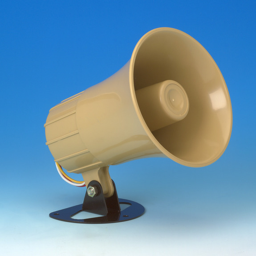

In [ ]:
Image.open('siren.jpg').convert('RGB').resize((256, 256))

In [ ]:
# lucidrains made a nice wrapper to make it really easy to fit an image
wrapper = SirenWrapper(
    net,
    image_width = 256,
    image_height = 256
)

opt = torch.optim.Adam(net.parameters(), lr=1e-3) # I just guessed a learning rate

for i in range(100):
  loss = wrapper(im) # Get's the net output and compares to an image for us
  opt.zero_grad() # Zero gradients
  loss.backward() # Backprop
  opt.step() # Update params

# To get the output
pred_img = wrapper() # (1, 3, 256, 256)

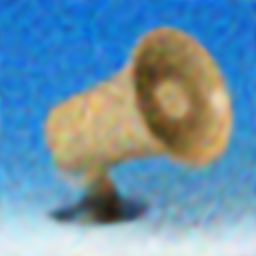

In [ ]:
# View
im_arr = np.array(255 * (pred_img.squeeze().permute(1, 2, 0).detach())).astype(np.uint8)
Image.fromarray(im_arr)

In [ ]:
sum([p.numel() for p in net.parameters()]) # Compare to 256*256*3 pixels

17027

In [ ]:
256*256*3

196608

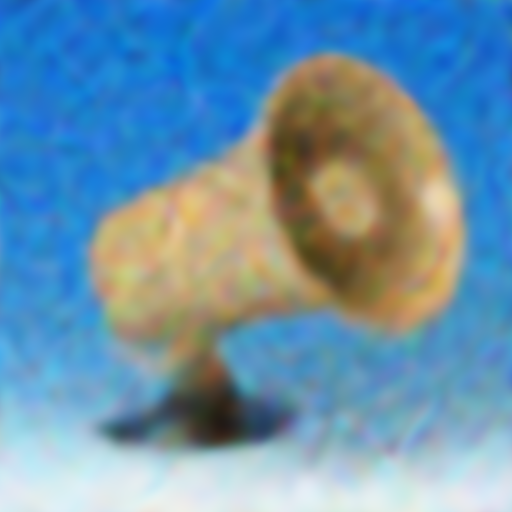

In [ ]:
# To see it at a larger size, we simply make a new wrapper:
wrapper = SirenWrapper(net,image_width = 512,image_height = 512)
pred_img = wrapper()
im_arr = np.array(255 * (pred_img.squeeze().permute(1, 2, 0).detach())).astype(np.uint8)
Image.fromarray(im_arr)

How low can we go?

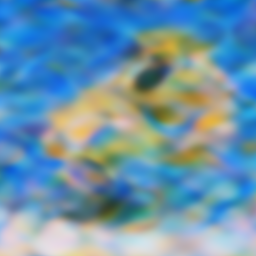

In [ ]:
#@title dim_hidden=16, num_layers=3
net = SirenNet(
    dim_in = 2,                        # input dimension, ex. 2d coordinates
    dim_hidden = 16,                  # hidden dimension
    dim_out = 3,                       # output dimension, ex. rgb value
    num_layers = 3,                    # number of layers
    final_activation = nn.Sigmoid(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 30.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
)


wrapper = SirenWrapper(
    net,
    image_width = 256,
    image_height = 256
)

opt = torch.optim.Adam(net.parameters(), lr=1e-3) # I just guessed a learning rate

for i in range(400):
  loss = wrapper(im) # Get's the net output and compares to an image for us
  opt.zero_grad() # Zero gradients
  loss.backward() # Backprop
  opt.step() # Update params

pred_img = wrapper()
im_arr = np.array(255 * (pred_img.squeeze().permute(1, 2, 0).detach())).astype(np.uint8)
Image.fromarray(im_arr)

In [ ]:
sum([p.numel() for p in net.parameters()]) # 16*16*3 = 768

643

In [ ]:
# Exercise: Can you use CLIP as part of the loss function to optimise a SIREN network towards a CLIP prompt?

My CLIP+SIREN notebook for those who'd prefer to just play with making pretty pictures: https://colab.research.google.com/drive/13OzZUG-rOGvhpYd-yhmosYJ8ZVpx8_m7?usp=sharing

Some artistic examples:

A shadertoy demo of a CLIP-designed SIREN shader I made: https://www.shadertoy.com/view/flGSDD

A much creepier SIREN-based shader by [Mario Klingemann](https://twitter.com/quasimondo): https://www.shadertoy.com/view/7sSSDd

[SIREN as a GAN ](https://twitter.com/cyrildiagne/status/1472612936174784514) by Cyril Diagne

[A vidoe on Neural SDFs](https://www.youtube.com/watch?v=8pwXpfi-0bU) by 
Blackle Mori, who inspired both Klingemann and I to make those SIREN shaders.

Some experiments I did last year training SIREN as a GAN: https://twitter.com/JohnowhitakerA/status/1478962276208099328

# 2.2 NeRF

![nerf gun gif](https://c.tenor.com/e9j9A_EXi98AAAAC/drunkensich-julian.gif)

I debated including a minimal NeRF example in this notebook, but 
- It takes a long time (multiple hours) to learn a scene
- My code was very messy
- There are MANY cool improvements and implementations out there
- We're running out of time

So, instead, let's just cover the basic ideas and then I'll list a bunch of resources for anyone wanting to look deeper.

![NERF image](https://api.wandb.ai/files/wandb/images/projects/833992/e618d75a.gif)

What if we'd like to learn a representation of a 3D scene that we can view from any direction. Perhaps we have pictures from some known angles but would like to fill in the gaps. One solution is a 'Neural Radiance Field', where we learn an implicit representation of the scene. Instead of just x and y, we'll now take a 3D position AND a direction as an input, and return a color AND a density as the output. To 'render' a scene from some viewpoint, we cast multiple parallel 'rays' into the volume, evaluating our function at many points along each ray. This is known as 'volume rendering' and it isn't as scary as it sounds.

When learning the scene, we 'render' from the known viewpoints and compare the results to our photographs. Once we're done, we can then also render the scene from new angles and hope that it still looks OK. If you've played with NeRFs, you'll know that this sometimes works amazingly and sometimes... doesn't :)

I think we'll leave it there since the live lessons starts in 8 minutes, but here are some resources to learn more:

### 2.2.1 Additional NeRF Resources:

Some Two Minute Papers videos: https://www.youtube.com/watch?v=nCpGStnayHk, https://www.youtube.com/watch?v=T29O-MhYALw, https://www.youtube.com/watch?v=j8tMk-GE8hY

Nerf Intro: https://datagen.tech/guides/synthetic-data/neural-radiance-field-nerf/

Pytorch Nerf: https://github.com/yenchenlin/nerf-pytorch (slow but fairly minimal code example if you like reading pytorch code)

Good explanation and JAX implementation: https://wandb.ai/wandb/nerf-jax/reports/Implementing-NeRF-in-JAX--VmlldzoxODA2NDk2?galleryTag=jax (also the source if the diagram above)

Grid-based methonds and other advances:

Relu fields - the little activation that could: https://geometry.cs.ucl.ac.uk/group_website/projects/2022/relu_fields/ (https://geometry.cs.ucl.ac.uk/group_website/projects/2022/relu_fields/static/docs/ReluFields_siggraph22_lowRes.pdf) (Code still private sadly) 

NVidias instant neural graphics primitives: https://github.com/NVlabs/instant-ngp

Fast NeRF with NVIDIAs tools (good place to start for practical NeRF stuff, fast training): https://developer.nvidia.com/blog/getting-started-with-nvidia-instant-nerfs/

Stylized nerf: http://geometrylearning.com/StylizedNeRF/

https://twitter.com/_ScottCondron/status/1535219176972992512 << A twitter thread with more good resources



## Section 3: Fond Goodbyes

![thats all folks gif](https://c.tenor.com/xvo8-YQ78P0AAAAC/porky-pig.gif)

I *think* we've reached the end of part 2 of AIAIART! 

Not sure what's next, but if you want to continue the discussions or be involved in future versions or spinoffs, do come and join our Discord - the link is listed in the readme of https://github.com/johnowhitaker/aiaiart

Cheers for now,

Jonathan